In [ ]:
import os
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    print('Running on CoLab')
    colab = True
    drive.mount('/content/gdrive')
    ! cp /content/gdrive/MyDrive/TheCatheterNinjas/kaggle.json .
else:
    colab = False
    print('Not running on CoLab')

In [ ]:
if colab:
    if not os.path.exists('./data/train.csv'):
        ! pip install --upgrade --force-reinstall --no-deps kaggle
        ! mkdir /root/.kaggle
        ! cp kaggle.json /root/.kaggle/
        ! chmod 600 /root/.kaggle/kaggle.json
        ! kaggle competitions download -c ranzcr-clip-catheter-line-classification -p ./
        ! unzip -qq ./'*.zip' -d ./
        ! rm ./'ranzcr-clip-catheter-line-classification.zip'
        print('files are ready')
    else:
        print('files are ready')

# Setup

## import libraries and modules

In [ ]:
if colab:
    ! pip install livelossplot

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.metrics import AUC
import warnings
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
import cv2
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
from livelossplot import PlotLossesKeras
import time

## make sure GPU are used

In [ ]:
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

## checking GPUs

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## functions

In [ ]:
def add_suffix(df: pd.DataFrame, col: str, suffix: str):
    df[col] = df[col] + suffix
    return df


def plot_model_history(history):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(15,7))
    for metric, values in history.history.items():
        ax.plot(np.arange(1, len(values) + 1), values, 'o-', label=metric)
    ax.set(xlabel='Epochs', ylabel='Rate %', 
           title='Model Trainning Metrics Per Epoch', 
           xlim=(1, len(values) + 0.2))
    sns.despine()
    plt.legend(loc='best')
    plt.show() 
    

def canny_edge_detection(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    return cv2.Canny(img, 50, 100)

def canny_over_clahe(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    high_contrast = clahe.apply(img)
    return cv2.Canny(high_contrast, 50, 100)

def enhanced_channels(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    high_contrast = clahe.apply(img)
    edges = cv2.Canny(high_contrast, 50, 100)
    return np.dstack((img, high_contrast, edges))

## Constants

In [ ]:
# data frame columns

ID: str = 'PatientID'
CASE: str = 'StudyInstanceUID'
    
# paths and directories

TRAIN_META: str = 'train.csv'
TRAIN_IMG_DIR: Path = Path('train')
MODEL_OUT: str = 'InceptionResNetV2_16b_5p_nadam'
PREDICTION_OUTPUT = 'predictions.csv'
CLASS_MODE: str = 'raw'
RSCL: float = 1./255.
GEN_PROPERTIES: dict = {'featurewise_center':False,'samplewise_center':False,
                        'featurewise_std_normalization':False, 
                        'samplewise_std_normalization':False,
                        'zca_whitening':False, 'zca_epsilon':1e-06,
                        'rotation_range':0, 'width_shift_range':0.0, 
                        'height_shift_range':0.0, 'brightness_range':None,
                        'shear_range':0.0, 'zoom_range':0.0, 
                        'channel_shift_range':0.0, 'fill_mode':"nearest", 
                        'cval':0.0, 'horizontal_flip':False, 
                        'vertical_flip':False, 'rescale':RSCL, 
                        'preprocessing_function':None, 'data_format':None, 
                        'validation_split':0.0, 'dtype':None}
# split and generators 

SUFFIX: str = '.jpg'
N_SPLITS: int = 1
PATIENCE: int = 5
TARGET_SIZE: tuple = (224,224)

# model parameters 
TRANSFER = InceptionResNetV2
TRAINABLE = True
TRANSFER_WEIGHTS = 'imagenet'
IMG_SIZE: tuple = (224, 224, 3)
OUT_ACTIVATION = 'sigmoid'
ACTIVATION = 'relu'
N_CLASS = 11
DENSE_DIM = 128
FLT = tf.keras.layers.Flatten(name='flat')
DNS = tf.keras.layers.Dense(DENSE_DIM, activation=ACTIVATION, name='dense')
OUT = tf.keras.layers.Dense(N_CLASS, activation=OUT_ACTIVATION, name='output')
LAYERS = [FLT, DNS, OUT]    

TRANSFER_PARAMETERS: dict = {'include_top': False, 'input_shape': IMG_SIZE, 
                             'weights': TRANSFER_WEIGHTS}

MONITOR = 'val_loss'
METRICS=AUC(multi_label=True)
OPTIMIZER = 'Nadam'
LOSS = 'binary_crossentropy'
EPOCHS = 100
BATCH_SIZE = 16

RANDOM_STATE = 42
VALIDATION_SIZE = 0.2

np.random.seed(RANDOM_STATE)

# Split

## load meta files

In [ ]:
train_df = pd.read_csv(TRAIN_META)

## define labels

In [ ]:
labels = train_df.select_dtypes(int).columns

## group split

In [ ]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=VALIDATION_SIZE, n_splits=N_SPLITS, random_state = RANDOM_STATE).split(train_df, groups=train_df[ID]))
train_df, valid_df = train_df.loc[train_inds], train_df.loc[val_inds]

## generators

In [ ]:
datagen=ImageDataGenerator(**GEN_PROPERTIES)

train_generator=datagen.flow_from_dataframe(dataframe=add_suffix(train_df, 
                                                                 col=CASE, 
                                                                 suffix=SUFFIX), 
                                            directory=str(TRAIN_IMG_DIR),
                                            x_col=CASE,
                                            y_col=labels,
                                            batch_size=BATCH_SIZE,
                                            seed=RANDOM_STATE,
                                            shuffle=True,
                                            class_mode=CLASS_MODE,
                                            target_size=TARGET_SIZE)


valid_generator=datagen.flow_from_dataframe(dataframe=add_suffix(valid_df, 
                                                                 col=CASE, 
                                                                 suffix=SUFFIX), 
                                            directory=str(TRAIN_IMG_DIR),
                                            x_col=CASE,
                                            y_col=labels,
                                            batch_size=BATCH_SIZE,
                                            seed=RANDOM_STATE,
                                            shuffle=True,
                                            class_mode=CLASS_MODE,
                                            target_size=TARGET_SIZE)

Found 24833 validated image filenames.
Found 5250 validated image filenames.


# setting Model

## get transfer model

In [ ]:
transfer_model = TRANSFER(**TRANSFER_PARAMETERS)

## add layers

In [ ]:
model = tf.keras.Sequential([transfer_model] + LAYERS)

## freeze transfer layers

In [ ]:
transfer_model.trainable=TRAINABLE

## checkout summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flat (Flatten)               (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4915328   
_________________________________________________________________
output (Dense)               (None, 11)                1419      
Total params: 59,253,483
Trainable params: 59,192,939
Non-trainable params: 60,544
_________________________________________________________________


## compile model

In [ ]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

## callback

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
lp = PlotLossesKeras()

callback = [es, lp]

# train

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=len(train_generator), validation_steps=len(valid_generator), epochs=EPOCHS, callbacks=callback)

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1553/1553 [==============================] - 639s 411ms/step - loss: 0.2483 - auc: 0.7528 - val_loss: 0.4216 - val_auc: 0.7347
Epoch 2/100
1553/1553 [==============================] - 637s 410ms/step - loss: 0.2186 - auc: 0.8042 - val_loss: 1.5530 - val_auc: 0.6176
Epoch 3/100
1553/1553 [==============================] - 622s 401ms/step - loss: 0.2166 - auc: 0.8119 - val_loss: 48.4988 - val_auc: 0.5713
Epoch 4/100
1553/1553 [==============================] - 619s 399ms/step - loss: 0.2051 - auc: 0.8407 - val_loss: 33.0044 - val_auc: 0.4928
Epoch 5/100
1553/1553 [==============================] - 616s 397ms/step - loss: 0.2045 - auc: 0.8420 - val_loss: 0.3309 - val_auc: 0.7312
Epoch 6/100
1553/1553 [==============================] - 620s 399ms/step - loss: 0.2015 - auc: 0.8485 - val_loss: 0.1969 - val_auc: 0.8486
Epoch 7/100
1553/1553 [==============================] - 619s 398ms/step - loss: 0.

### plot model history

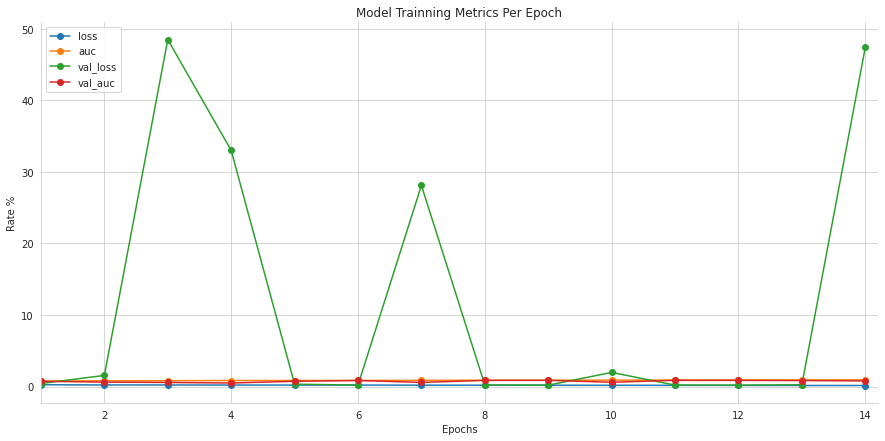

In [ ]:
plot_model_history(model.history)

# Save model

In [ ]:
model.save(MODEL_OUT)

INFO:tensorflow:Assets written to: InceptionResNetV2_16b_5p_ftrl/assets
